In [1]:
import numpy as np
from sympy import *
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Solving Performance Goal 1: Hover 1m above ground for 2 minutes.

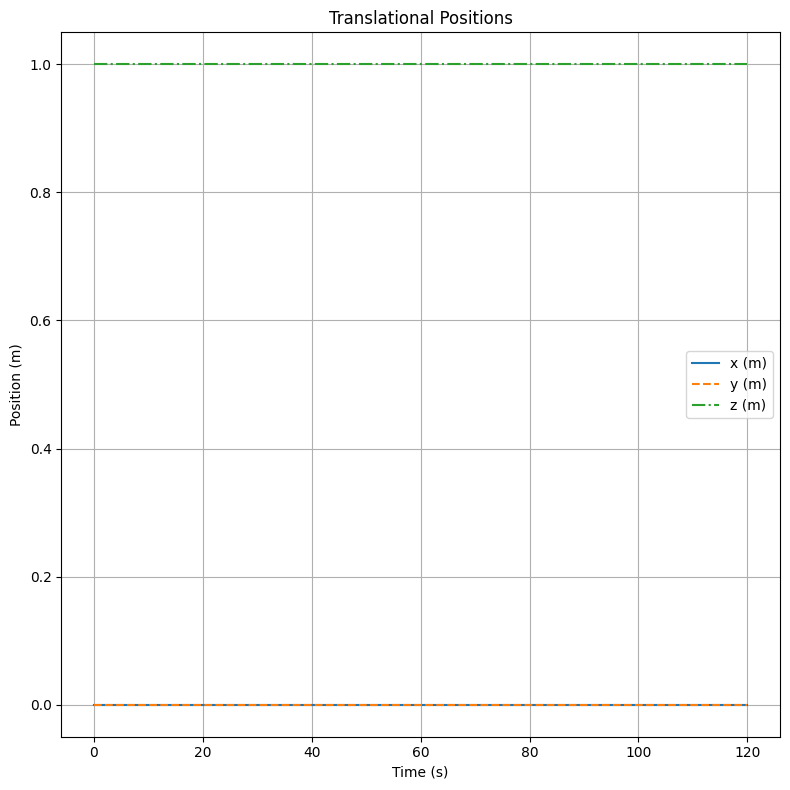

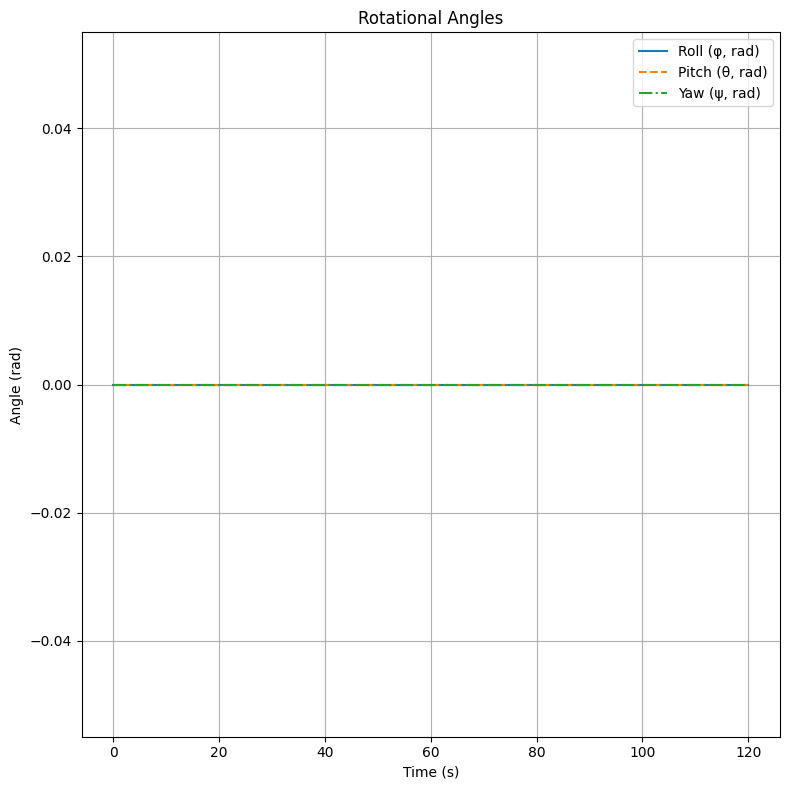

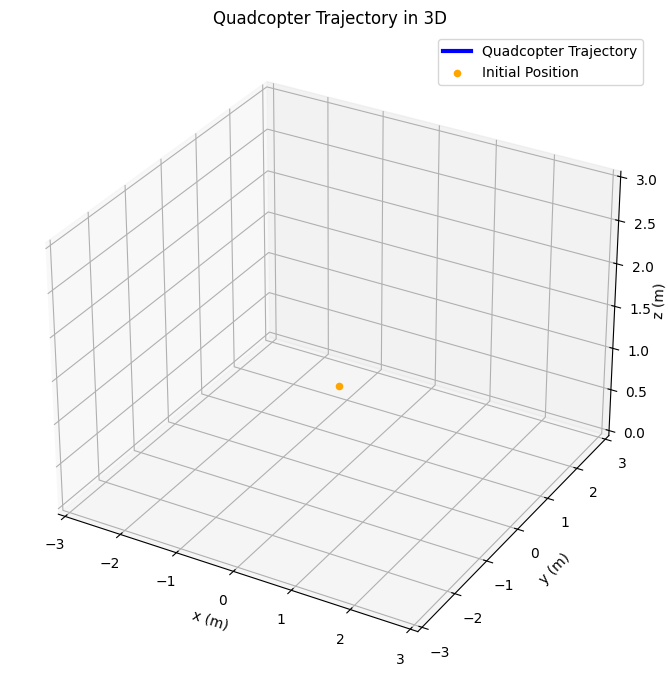

In [2]:
# Define constants
Ixx, Iyy, Izz = 0.00487549, 0.00487549, 0.00961741  # Moments of inertia (kg·m²)
m = .675  # Mass (kg)
g = 9.81  # Gravitational acceleration (m/s²)
#k and b are values provided from a reasearch paper
k = 2.980e-6 # Lift coefficient
b = 1.140e-7 # Drag coefficient
l = 0.1778   # Distance from the C.O.M to the rotor (m)

# Define the rotor-generated torques and thrust as simple placeholders
def rotor_forces_torques(rotor_speeds,k,b,l):
    # Rotor speeds (inputs) control torques (N·m) and thrust (N)
    T =  k*(rotor_speeds[0]**2+rotor_speeds[1]**2+rotor_speeds[2]**2+rotor_speeds[3]**2)  # Total thrust
    tau_phi = l*k*(rotor_speeds[3]**2 - rotor_speeds[1]**2)  # Roll torque
    tau_theta = l*k*(rotor_speeds[2]**2 - rotor_speeds[0]**2)  # Pitch torque
    tau_psi = b*(rotor_speeds[0]**2 - rotor_speeds[1]**2 + rotor_speeds[2]**2 - rotor_speeds[3]**2)  # Yaw torque
    return T, tau_phi, tau_theta, tau_psi

# Define the dynamics
def quadcopter_dynamics(t, state, rotor_speeds):
    # Unpack state
    x, y, z, phi, theta, psi, x_dot, y_dot, z_dot, omega1, omega2, omega3 = state

    R_phi = np.array([[1,0,0],
                    [0,np.cos(phi),-np.sin(phi)],
                    [0,np.sin(phi), np.cos(phi)]])
    R_theta = np.array([[np.cos(theta),0,np.sin(theta)],
                      [0,1,0],
                      [-np.sin(theta),0,np.cos(theta)]])
    R_psi = np.array([[np.cos(psi),-np.sin(psi),0],
                    [np.sin(psi),np.cos(psi),0],
                    [0,0,1]])

    #Rotation Matrix to go from body frame to inertial frame
    R = R_psi @ R_theta @ R_phi

    # Compute forces and torques
    T, tau_phi, tau_theta, tau_psi = rotor_forces_torques(rotor_speeds,k,b,l)

    # Translational dynamics
    x_ddot = (T / m) * R[0, 2]
    y_ddot = (T / m) * R[1, 2]
    z_ddot = (T / m) * R[2, 2] - g

    # Rotational dynamics (Euler equations)
    omega1_dot = (tau_phi + (Iyy - Izz) * omega2 * omega3) / Ixx
    omega2_dot = (tau_theta + (Izz - Ixx) * omega3 * omega1) / Iyy
    omega3_dot = (tau_psi + (Ixx - Iyy) * omega1 * omega2) / Izz

    # Euler angle rates
    B_inv = (1 / np.cos(theta))*np.array([
         [0, np.sin(psi) * np.tan(theta), np.cos(psi) * np.tan(theta)],
         [0, np.cos(psi)*np.cos(theta), -np.cos(theta)*np.sin(psi)],
         [np.cos(theta), np.sin(theta)*np.sin(psi), np.sin(theta)*np.cos(psi)],
    ])

    #B_inv = np.array([
        #[1, np.sin(phi) * np.tan(theta), np.cos(phi) * np.tan(theta)],
        #[0, np.cos(phi), -np.sin(phi)],
        #[0, np.sin(phi) / np.cos(theta), np.cos(phi) / np.cos(theta)],
    #])

    euler_rates = B_inv @ np.array([omega1, omega2, omega3])

    phi_dot, theta_dot, psi_dot = euler_rates

    # Return derivatives
    return [
        x_dot, y_dot, z_dot,  # Position derivatives
        phi_dot, theta_dot, psi_dot,  # Euler angles derivatives
        x_ddot, y_ddot, z_ddot,  # Velocity derivatives
        omega1_dot, omega2_dot, omega3_dot  # Angular velocity derivatives
    ]

# Initial state [x, y, z, phi, theta, psi, x_dot, y_dot, z_dot, omega1, omega2, omega3]
initial_state = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Rotor speeds (inputs)
#Current rpm corresponds to angular velocities needed for hovering
rotor_speeds = [745.3294168335, 745.3294168335, 745.3294168335, 745.3294168335]  # Adjust for testing (RPM or similar units)

# Time range for simulation
t_span = (0, 120)  # Simulate for 120 seconds
t_eval = np.linspace(*t_span, 100)  # 100 time points for plotting

# Solve the system of equations
sol = solve_ivp(quadcopter_dynamics, t_span, initial_state, args=(rotor_speeds,), t_eval=t_eval,atol=1e-9, rtol=1e-6)


# Plot translational positions (x, y, z) together
plt.figure(figsize=(8,8))
plt.plot(sol.t, sol.y[0], label='x (m)', linestyle='-')  # x
plt.plot(sol.t, sol.y[1], label='y (m)', linestyle='--')  # y
plt.plot(sol.t, sol.y[2], label='z (m)', linestyle='-.')  # z
plt.title('Translational Positions')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.tight_layout()

# Plot rotational angles (φ, θ, ψ) together
plt.figure(figsize=(8,8))
plt.plot(sol.t, sol.y[3], label='Roll (φ, rad)', linestyle='-')  # phi
plt.plot(sol.t, sol.y[4], label='Pitch (θ, rad)', linestyle='--')  # theta
plt.plot(sol.t, sol.y[5], label='Yaw (ψ, rad)', linestyle='-.')  # psi
plt.title('Rotational Angles')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid()
plt.tight_layout()

# Plot 3D plot for the trajectoy
fig_3D = plt.figure(figsize=(8,8))
ax = fig_3D.add_subplot(111, projection='3d')
ax.plot3D(sol.y[0], sol.y[1], sol.y[2], label='Quadcopter Trajectory', color='b', linewidth=3)
ax.scatter(sol.y[0][0], sol.y[1][0], sol.y[2][0], color='orange', s=20, label='Initial Position')
ax.set_title('Quadcopter Trajectory in 3D')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)', labelpad=-1)
ax.legend()
ax.grid()
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(0, 3)
fig_3D.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

# Show the plots
plt.show()

Solving Performance Goal 2: Fly in a circle of radius 2m, at an altitude of 1m above ground at a speed of 0.5m/s for at least 1 minute.

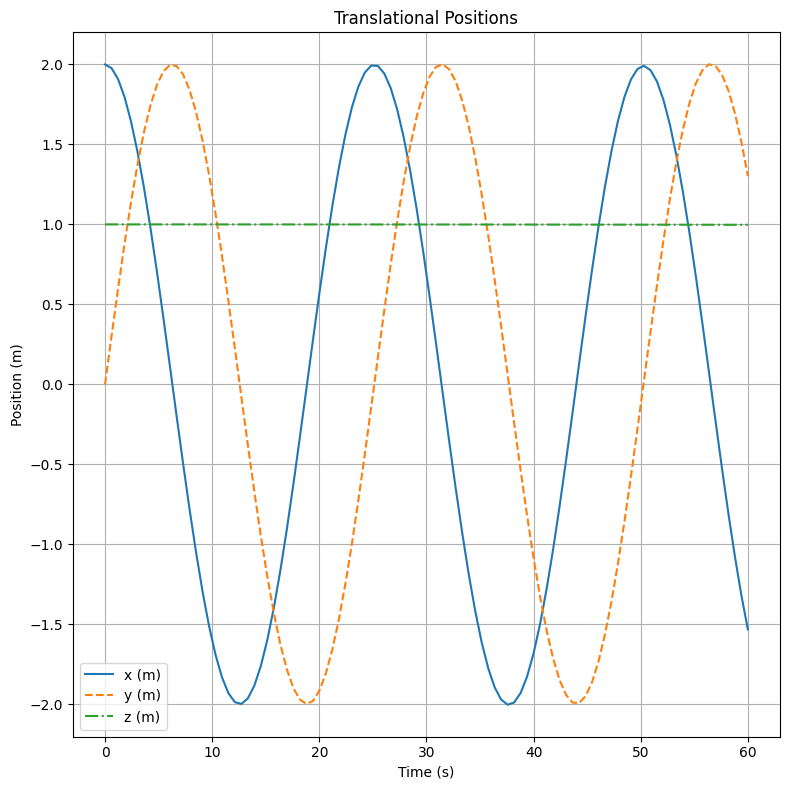

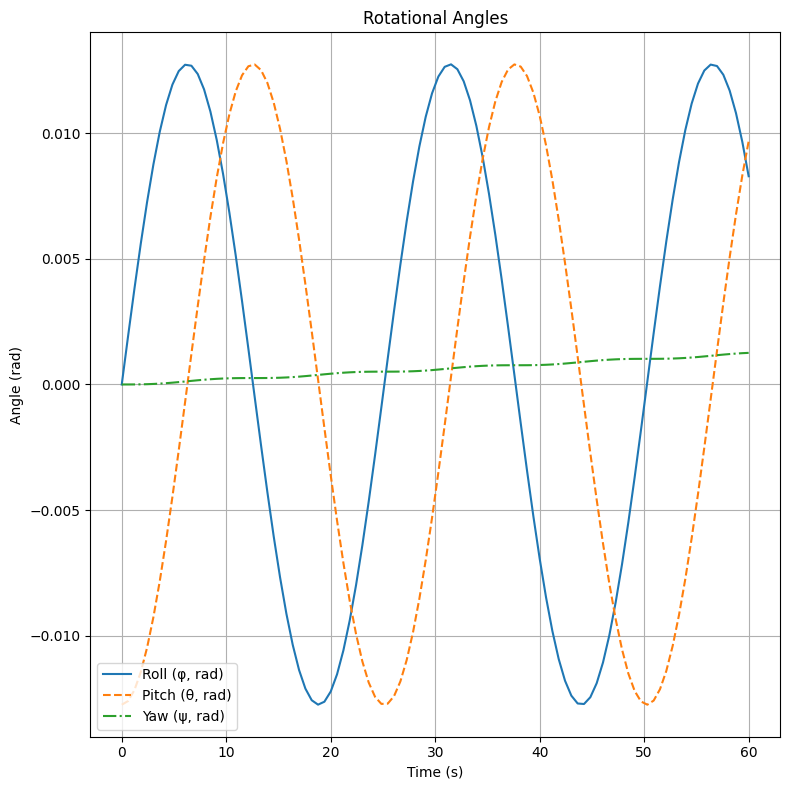

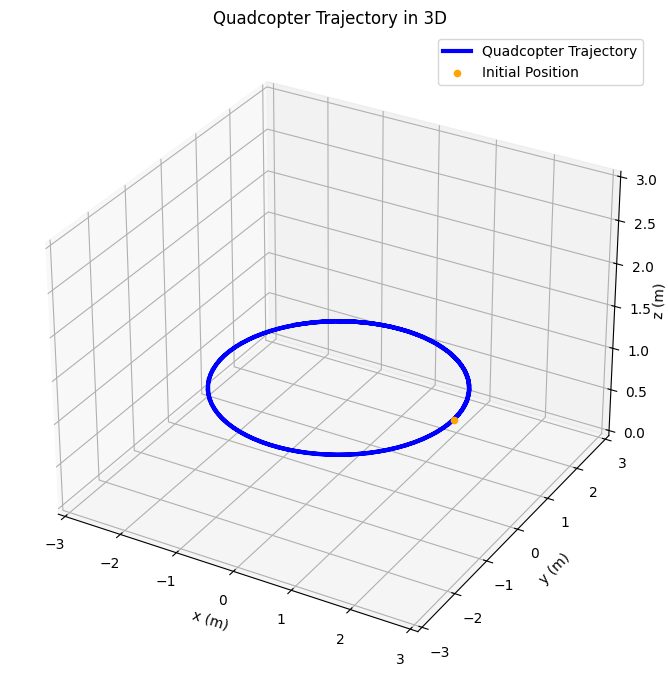

In [ ]:
# Define constants
Ixx, Iyy, Izz = 0.00487549, 0.00487549, 0.00961741  # Moments of inertia (kg·m²)
m = .675  # Mass (kg)
g = 9.81  # Gravitational acceleration (m/s²)
#k and b are values provided from a reasearch paper
k = 2.980e-6 # Lift coefficient
b = 1.140e-7 # Drag coefficient
l = 0.1778   # Distance from the C.O.M to the rotor (m)

#Hovering RPM with slight offset
w_h = 745.3294168335-0.0303 #(rad/s)

#Angular velocity for the desired circular trajectory
w_circle = 0.25 #rad/s

#Define time-dependent roll and pitch angles
def phi_t(t):
  return .0127417104*np.sin(w_circle*t)

def theta_t(t):
  return .0127417104*np.cos(w_circle*t)

#Define time-dependent rotor speeds
def rotor_speeds(t, w_h):

  phi = phi_t(t)
  theta = theta_t(t)

  omega1 = w_h*(1-phi-theta)
  omega2 = w_h*(1-phi+theta)
  omega3 = w_h*(1+phi+theta)
  omega4 = w_h*(1+phi-theta)

  return [omega1, omega2, omega3, omega4]

#Define time-dependent angular velocities
def angular_veocities(t):

  omega_1 = .0127417104*w_circle*np.cos(w_circle*t)
  omega_2 = .0127417104*w_circle*np.sin(w_circle*t)
  omega_3 = 0

  return omega_1, omega_2, omega_3


# Define the rotor-generated torques and thrust
def rotor_forces_torques(rotor_speeds,k,b,l):
    # Rotor speeds (inputs) control torques (N·m) and thrust (N)
    #k is a lift constant
    #b is a drag constant
    #l is the distance from the C.O.M to the rotor

    T =  k*(rotor_speeds[0]**2+rotor_speeds[1]**2+rotor_speeds[2]**2+rotor_speeds[3]**2)  # Total thrust
    tau_phi = l*k*(rotor_speeds[3]**2 - rotor_speeds[1]**2)  # Roll torque
    tau_theta = l*k*(rotor_speeds[2]**2 - rotor_speeds[0]**2)  # Pitch torque
    tau_psi = b*(rotor_speeds[0]**2 - rotor_speeds[1]**2 + rotor_speeds[2]**2 - rotor_speeds[3]**2)  # Yaw torque
    return T, tau_phi, tau_theta, tau_psi

# Define the dynamics
def quadcopter_dynamics(t, state, rotor_speeds):
    # Unpack state
    x, y, z, phi, theta, psi, x_dot, y_dot, z_dot, omega1, omega2, omega3 = state


    R_phi = np.array([[1,0,0],
                    [0,np.cos(phi),-np.sin(phi)],
                    [0,np.sin(phi), np.cos(phi)]])

    R_theta = np.array([[np.cos(theta),0,np.sin(theta)],
                      [0,1,0],
                      [-np.sin(theta),0,np.cos(theta)]])

    R_psi = np.array([[np.cos(psi),-np.sin(psi),0],
                    [np.sin(psi),np.cos(psi),0],
                    [0,0,1]])

    #Rotation Matrix to go from body frame to inertial frame
    R = R_psi @ R_theta @ R_phi

    #Compute the angular velocities for each timestep
    omega1, omega2, omega3 = angular_veocities(t)

    # Compute rotor speeds for each timestep
    rotor_speeds = rotor_speeds(t,w_h)

    # Compute forces and torques for each timestep
    T, tau_phi, tau_theta, tau_psi = rotor_forces_torques(rotor_speeds,k,b,l)

    # Translational dynamics
    x_ddot = (T / m) * R[0, 2]
    y_ddot = (T / m) * R[1, 2]
    z_ddot = (T / m) * R[2, 2] - g

    # Rotational dynamics (Euler equations)
    omega1_dot = (tau_phi + (Iyy - Izz) * omega2 * omega3) / Ixx
    omega2_dot = (tau_theta + (Izz - Ixx) * omega3 * omega1) / Iyy
    omega3_dot = (tau_psi + (Ixx - Iyy) * omega1 * omega2) / Izz

    # Euler angle rates

    #Matrix to transform between Angular velocities and euler rates
    B_inv = np.array([
        [1, np.sin(phi) * np.tan(theta), np.cos(phi) * np.tan(theta)],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi) / np.cos(theta), np.cos(phi) / np.cos(theta)],
    ])

    euler_rates = B_inv @ np.array([omega1, omega2, omega3])

    phi_dot, theta_dot, psi_dot = euler_rates

    #psi_dot = 0

    # Return derivatives
    return [
        x_dot, y_dot, z_dot,  # Position derivatives
        phi_dot, theta_dot, psi_dot,  # Euler angles derivatives
        x_ddot, y_ddot, z_ddot,  # Velocity derivatives
        omega1_dot, omega2_dot, omega3_dot  # Angular velocity derivatives
    ]

# Initial state [x, y, z, phi, theta, psi, x_dot, y_dot, z_dot, omega1, omega2, omega3]
initial_state = [2, 0, 1, 0, -.0127417104, 0, 0, .5, 0, angular_veocities(0)[0], angular_veocities(0)[1], angular_veocities(0)[2]]

#theta value is due to centripetal acceleration, must be banked -.012 radians to have proper thrust


# Time range for simulation
t_span = (0, 60)  # Simulate for 60 seconds
t_eval = np.linspace(0, 60, 100)  # 100 time points for plotting

# Solve the system of equations
sol = solve_ivp(quadcopter_dynamics, t_span, initial_state, args=(rotor_speeds,), t_eval=t_eval,atol=1e-9, rtol=1e-6)


# Plot translational positions (x, y, z) together
plt.figure(figsize=(8,8))
plt.plot(sol.t, sol.y[0], label='x (m)', linestyle='-')  # x
plt.plot(sol.t, sol.y[1], label='y (m)', linestyle='--')  # y
plt.plot(sol.t, sol.y[2], label='z (m)', linestyle='-.')  # z
plt.title('Translational Positions')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.tight_layout()

# Plot rotational angles (φ, θ, ψ) together
plt.figure(figsize=(8,8))
plt.plot(sol.t, sol.y[3], label='Roll (φ, rad)', linestyle='-')  # phi
plt.plot(sol.t, sol.y[4], label='Pitch (θ, rad)', linestyle='--')  # theta
plt.plot(sol.t, sol.y[5], label='Yaw (ψ, rad)', linestyle='-.')  # psi
plt.title('Rotational Angles')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid()
plt.tight_layout()

# Plot 3D plot for the trajectoy
fig_3D = plt.figure(figsize=(8,8))
ax = fig_3D.add_subplot(111, projection='3d')
ax.plot3D(sol.y[0], sol.y[1], sol.y[2], label='Quadcopter Trajectory', color='b', linewidth=3)
ax.scatter(sol.y[0][0], sol.y[1][0], sol.y[2][0], color='orange', s=20, label='Initial Position')
ax.set_title('Quadcopter Trajectory in 3D')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)', labelpad=-1)
ax.legend()
ax.grid()
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(0, 3)
fig_3D.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

# Show the plots
plt.show()

Solving Performance Goal 3: Launch from ground and ascend vertically until 1m
above ground. Move in a straight line 1m above ground at an average
speed of 1m/s for 5m, stop (hover), yaw 90 deg to the left, move in another
straight line for 5m, stop (hover), land vertically with a speed of no more
than 1cm/s.

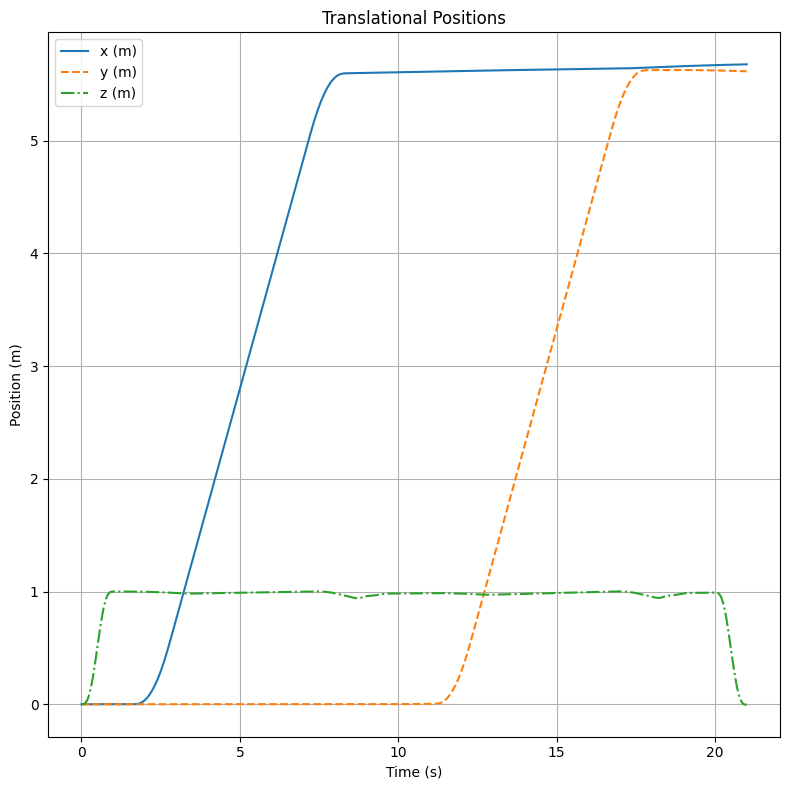

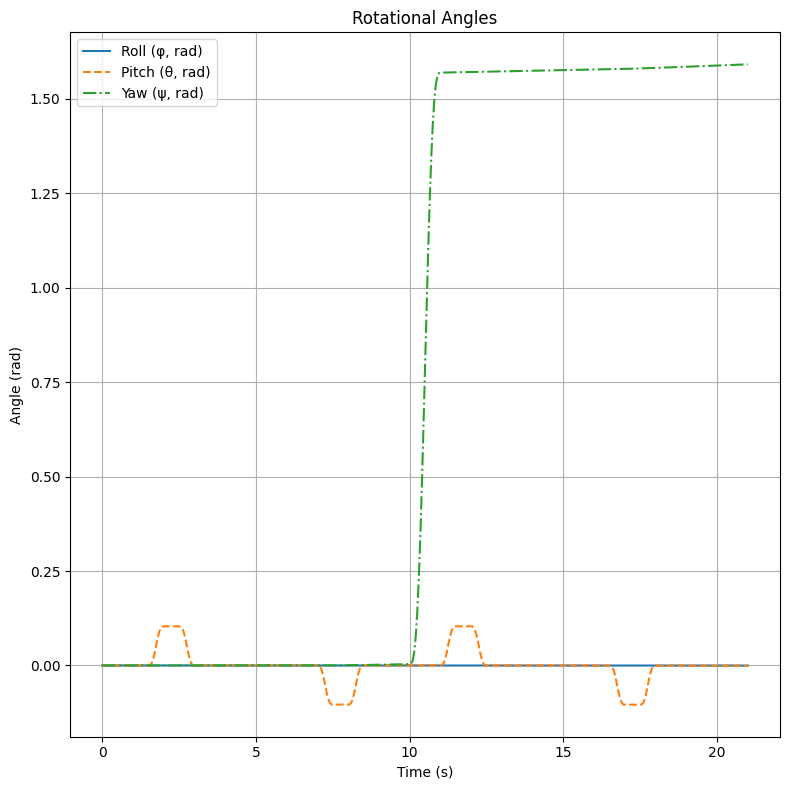

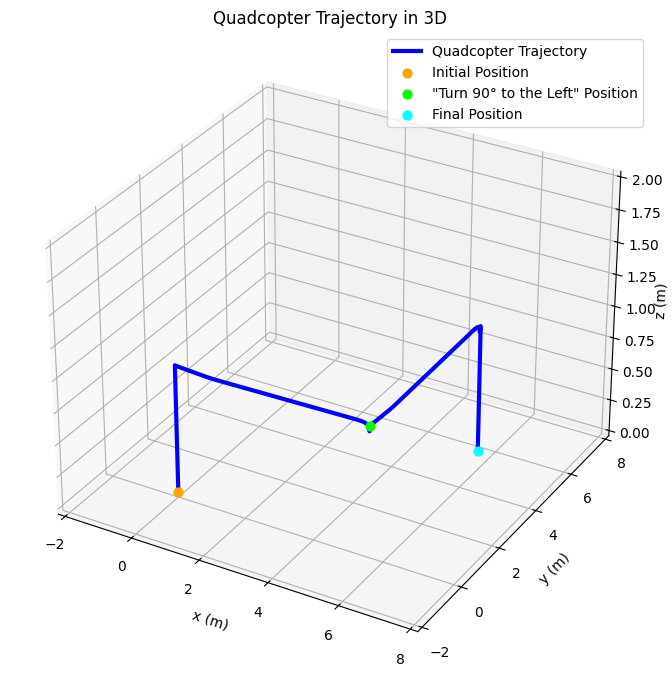

In [ ]:
# Define constants
Ixx, Iyy, Izz = 0.00487549, 0.00487549, 0.00961741  # Moments of inertia (kg·m²)
m = .675  # Mass (kg)
g = 9.81  # Gravitational acceleration (m/s²)
# k and b are values provided from a reasearch paper
k = 2.980e-6 # Lift coefficient
b = 1.140e-7 # Drag coefficient
l = 0.1778   # Distance from the C.O.M to the rotor (m)

# Define the rotor-generated torques and thrust as simple placeholders
def rotor_forces_torques(rotor_speeds,k,b,l):
    # Rotor speeds (inputs) control torques (N·m) and thrust (N)
    T =  k*(rotor_speeds[0]**2+rotor_speeds[1]**2+rotor_speeds[2]**2+rotor_speeds[3]**2)  # Total thrust
    tau_phi = l*k*(rotor_speeds[3]**2 - rotor_speeds[1]**2)  # Roll torque
    tau_theta = l*k*(rotor_speeds[2]**2 - rotor_speeds[0]**2)  # Pitch torque
    tau_psi = b*(rotor_speeds[0]**2 - rotor_speeds[1]**2 + rotor_speeds[2]**2 - rotor_speeds[3]**2)  # Yaw torque
    return T, tau_phi, tau_theta, tau_psi

# Define the dynamics
def quadcopter_dynamics(t, state, rotor_speeds_func):
    # Unpack state
    x, y, z, phi, theta, psi, x_dot, y_dot, z_dot, omega1, omega2, omega3 = state

    rotor_speeds = rotor_speeds_func(t, w_hover)

    R_phi = np.array([[1,0,0],
                    [0,np.cos(phi),-np.sin(phi)],
                    [0,np.sin(phi), np.cos(phi)]])
    R_theta = np.array([[np.cos(theta),0,np.sin(theta)],
                      [0,1,0],
                      [-np.sin(theta),0,np.cos(theta)]])
    R_psi = np.array([[np.cos(psi),-np.sin(psi),0],
                    [np.sin(psi),np.cos(psi),0],
                    [0,0,1]])

    # Rotation Matrix to go from body frame to inertial frame
    R = R_psi @ R_theta @ R_phi

    # Compute forces and torques
    T, tau_phi, tau_theta, tau_psi = rotor_forces_torques(rotor_speeds,k,b,l)

    # Translational dynamics
    x_ddot = (T / m) * R[0, 2]
    y_ddot = (T / m) * R[1, 2]
    z_ddot = (T / m) * R[2, 2] - g

    # Rotational dynamics (Euler equations)
    omega1_dot = (tau_phi + (Iyy - Izz) * omega2 * omega3) / Ixx
    omega2_dot = (tau_theta + (Izz - Ixx) * omega3 * omega1) / Iyy
    omega3_dot = (tau_psi + (Ixx - Iyy) * omega1 * omega2) / Izz

    # Euler angle rates
    B_inv = np.array([
        [1, np.sin(phi) * np.tan(theta), np.cos(phi) * np.tan(theta)],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi) / np.cos(theta), np.cos(phi) / np.cos(theta)],
    ])

    euler_rates = B_inv @ np.array([omega1, omega2, omega3])

    phi_dot, theta_dot, psi_dot = euler_rates

    # Return derivatives
    return [
        x_dot, y_dot, z_dot,  # Position derivatives
        phi_dot, theta_dot, psi_dot,  # Euler angles derivatives
        x_ddot, y_ddot, z_ddot,  # Velocity derivatives
        omega1_dot, omega2_dot, omega3_dot  # Angular velocity derivatives
    ]

# Initial state [x, y, z, phi, theta, psi, x_dot, y_dot, z_dot, omega1, omega2, omega3]
initial_state = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Define constants
w_hover = 745.3294168335      # rad/s needed by each rotor for hovering condition
max_h_c = 214.482             # (a) Constant to determine maximum height of ascent (max_height_constant)
vel_c = 8                     # (b) Constant to determine how fast the quadcopter travels in a straight line (velocity_constant)
hover_c = 40                  # (c) Constant to determine how fast to bring quadcopter back to hover at z=1 (hover_constant)
turn_c = 130.145              # (d) Constant to determine the maximum angle to yaw (turn_constant)

# Define step function to turn rotors on/off (make the graph piecewise)
def H(x):                             # Function "turns on" when x>=0 ; H = 0 when x negative, H = 1 when x = 0 and x positive
  return np.where(x < 0, 0, 1)
def H_begin(t, t_start, t_stop):      # Commonly used time range: turns on function from t_start to halfway between t_start and t_stop
  return H((t_stop-t_start)/2 + t_start - t)*H(t-t_start)
def H_end(t, t_start, t_stop):        # Commonly used time range: turns on functions from halfway point to t_stop
  return H(t_stop-t)*H(t-((t_stop-t_start)/2 + t_start) - .001)   #-.001 included so that values exactly at halfway point aren't double counted


# Define multiplier (when one rotor increased by x, other rotor needs to be decreased by this amount to maintain z=constant)
# Derived from 2*(w_hover)^2 = (w_hover + x)^2 + (w_hover - neg_multiplier)^2, use quadratic formula
def neg_multiplier(x, w_hover):
  return (2*w_hover - ((2*w_hover)**2 - 4*(2*w_hover*x + x**2))**.5) / 2


# Define function for the ascent of the quadcopter
def ascend(t, a, t_start, t_stop):   # a = max_height_constant
  return a*H_begin(t, t_start, t_stop)*np.sin((2*np.pi)*t) - H_end(t, t_start, t_stop)*neg_multiplier(a*np.sin((2*np.pi)*(t-t_stop/2)), w_hover)


# Define functions to create a pitch to move straight (01 correstonds to rotor 1, 03 to rotor 3, and 24 to rotors 2 and 4)
def move_straight_01(t, b, t_start, t_stop, t_end):   # b = velocity_constant
  return -H_begin(t, t_start, t_stop)*neg_multiplier(b*np.sin(4*np.pi*(t-t_start)), w_hover) + H_end(t, t_start, t_stop)*b*np.sin((4*np.pi)*(t-t_start+(t_stop-t_start)/2)) + move_straight_24(t, b, t_start, t_stop, t_end)

def move_straight_03(t, b, t_start, t_stop, t_end):   # b = velocity_constant
  return H_begin(t, t_start, t_stop)*b*np.sin(4*np.pi*(t-t_start)) - H_end(t, t_start, t_stop)*neg_multiplier(b*np.sin((4*np.pi)*(t-t_start+(t_stop-t_start)/2)), w_hover) + move_straight_24(t, b, t_start, t_stop, t_end)

def move_straight_24(t, b, t_start, t_stop, t_end):
  return H(t_end-t)*H(t-t_stop)*(746.5537967467653 + .9 - w_hover)


# Define funcitons to bring pitch back to 0 so that x_ddot = 0
def slow_01(t, b, t_start, t_stop, t_end):   # b = velocity_constant
  return H_begin(t, t_start, t_stop)*b*np.sin((4*np.pi)*(t-t_start)) - H_end(t, t_start, t_stop)*neg_multiplier(b*np.sin((4*np.pi)*(t-t_start+(t_stop-t_start)/2)), w_hover) + slow_24(t, b, t_start, t_stop, t_end)

def slow_03(t, b, t_start, t_stop, t_end):   # b = velocity_constant
  return -H_begin(t, t_start, t_stop)*neg_multiplier(b*np.sin(4*np.pi*(t-t_start)), w_hover) + H_end(t, t_start, t_stop)*b*np.sin((4*np.pi)*(t-t_start+(t_stop-t_start)/2)) + slow_24(t, b, t_start, t_stop, t_end)

def slow_24(t, b, t_start, t_stop, t_end):
  return H(t_end-t)*H(t-t_stop)*1.85


# Recover hover: due to small rounding/human error, the values of x, y, z, phi, theta, and psi can get off by small factors. over time, these values grow, so a recover function is needed to bring the z value back to 1
def recover(t, c, t_start, t_stop):   # c = hover_constant
  return H_begin(t, t_start, t_stop)*c*np.sin((np.pi)*(t-t_start)) - H_end(t, t_start, t_stop)*neg_multiplier(c*np.sin((np.pi)*(t-t_start+(t_stop-t_start)/2)), w_hover)


# Define functions to yaw
def yaw13(t, d, t_start, t_stop):   # d = turn_constant
  return H_begin(t, t_start, t_stop)*d*np.sin(2*np.pi*(t-t_start)) - H_end(t, t_start, t_stop)*neg_multiplier(d*np.sin((2*np.pi)*(t-t_start+(t_stop-t_start)/2)), w_hover)

def yaw24(t, d, t_start, t_stop):   # d = turn_constant
  return -H_begin(t, t_start, t_stop)*neg_multiplier(d*np.sin(2*np.pi*(t-t_start)), w_hover) + H_end(t, t_start, t_stop)*d*np.sin((2*np.pi)*(t-t_start+(t_stop-t_start)/2))


# Define function for the descent of the quadcopter
def descend(t, a, t_start, t_stop):   # a = max_height_constant
  return -H_begin(t, t_start, t_stop)*neg_multiplier(a*np.sin((2*np.pi)*(t-t_start)), w_hover) + a*H_end(t, t_start, t_stop)*np.sin((2*np.pi)*(t-t_start+(t_stop-t_start)/2))

# Define function to change the rotor speeds over time: start with hovering speed, and to it for each section of the journey. The final result will be the path required in perfomance goal three, with each section being turned on by the times declared in the function.
def rotor_speeds(t, w_hover):
  omega1 = w_hover + ascend(t, max_h_c, 0, 1) + move_straight_01(t, vel_c, 1.5, 2, 2.5) + slow_01(t, vel_c, 2.5, 3, 3.5) - move_straight_01(t, vel_c, 7, 7.5, 8) - slow_01(t, vel_c, 8, 8.5, 9) + recover(t, hover_c, 8.5, 9.25) + recover(t, 15, 9.35, 9.65) + yaw13(t, turn_c, 10, 11) + move_straight_01(t, vel_c, 11, 11.5, 12) + slow_01(t, vel_c, 12, 12.5, 13) - move_straight_01(t, vel_c, 16.5, 17, 17.5) - slow_01(t, vel_c, 17.5, 18, 18.5) + recover(t, hover_c, 18, 18.75) + recover(t, 15, 18.85, 19.15) + descend(t, max_h_c, 20, 21)
  omega2 = w_hover + ascend(t, max_h_c, 0, 1) + move_straight_24(t, vel_c, 1.5, 2, 2.5) + slow_24(t, vel_c, 2.5, 3, 3.5) - move_straight_24(t, vel_c, 7, 7.5, 8) - slow_24(t, vel_c, 8, 8.5, 9) + recover(t, hover_c, 8.5, 9.25) + recover(t, 15, 9.35, 9.65) + yaw24(t, turn_c, 10, 11) + move_straight_24(t, vel_c, 11, 11.5, 12) + slow_24(t, vel_c, 12, 12.5, 13) - move_straight_24(t, vel_c, 16.5, 17, 17.5) - slow_24(t, vel_c, 17.5, 18, 18.5) + recover(t, hover_c, 18, 18.75) + recover(t, 15, 18.85, 19.15) + descend(t, max_h_c, 20, 21)
  omega3 = w_hover + ascend(t, max_h_c, 0, 1) + move_straight_03(t, vel_c, 1.5, 2, 2.5) + slow_03(t, vel_c, 2.5, 3, 3.5) - move_straight_03(t, vel_c, 7, 7.5, 8) - slow_03(t, vel_c, 8, 8.5, 9) + recover(t, hover_c, 8.5, 9.25) + recover(t, 15, 9.35, 9.65) + yaw13(t, turn_c, 10, 11) + move_straight_03(t, vel_c, 11, 11.5, 12) + slow_03(t, vel_c, 12, 12.5, 13) - move_straight_03(t, vel_c, 16.5, 17, 17.5) - slow_03(t, vel_c, 17.5, 18, 18.5) + recover(t, hover_c, 18, 18.75) + recover(t, 15, 18.85, 19.15) + descend(t, max_h_c, 20, 21)
  omega4 = w_hover + ascend(t, max_h_c, 0, 1) + move_straight_24(t, vel_c, 1.5, 2, 2.5) + slow_24(t, vel_c, 2.5, 3, 3.5) - move_straight_24(t, vel_c, 7, 7.5, 8) - slow_24(t, vel_c, 8, 8.5, 9) + recover(t, hover_c, 8.5, 9.25) + recover(t, 15, 9.35, 9.65) + yaw24(t, turn_c, 10, 11) + move_straight_24(t, vel_c, 11, 11.5, 12) + slow_24(t, vel_c, 12, 12.5, 13) - move_straight_24(t, vel_c, 16.5, 17, 17.5) - slow_24(t, vel_c, 17.5, 18, 18.5) + recover(t, hover_c, 18, 18.75) + recover(t, 15, 18.85, 19.15) + descend(t, max_h_c, 20, 21)
  return [omega1, omega2, omega3, omega4]

# Time range for simulation
t_span = (0, 21)  # Simulate for 21 seconds
t_eval = np.linspace(*t_span, 421)  # 421 time points for plotting (one point for every .5 seconds)

# Solve the system of equations
sol = solve_ivp(quadcopter_dynamics, t_span, initial_state, args=(rotor_speeds,), t_eval=t_eval,atol=1e-9, rtol=1e-6)

# Plot translational positions (x, y, z) together
plt.figure(figsize=(8,8))
plt.plot(sol.t, sol.y[0], label='x (m)', linestyle='-')  # x
plt.plot(sol.t, sol.y[1], label='y (m)', linestyle='--')  # y
plt.plot(sol.t, sol.y[2], label='z (m)', linestyle='-.')  # z
plt.title('Translational Positions')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.tight_layout()

# Plot rotational angles (φ, θ, ψ) together
plt.figure(figsize=(8,8))
plt.plot(sol.t, sol.y[3], label='Roll (φ, rad)', linestyle='-')  # phi
plt.plot(sol.t, sol.y[4], label='Pitch (θ, rad)', linestyle='--')  # theta
plt.plot(sol.t, sol.y[5], label='Yaw (ψ, rad)', linestyle='-.')  # psi
plt.title('Rotational Angles')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid()
plt.tight_layout()

# Plot 3D plot for the trajectoy
fig_3D = plt.figure(figsize=(8,8))
ax = fig_3D.add_subplot(111, projection='3d')
ax.plot3D(sol.y[0], sol.y[1], sol.y[2], label='Quadcopter Trajectory', color='b', linewidth=3)
ax.scatter(sol.y[0][0], sol.y[1][0], sol.y[2][0], color='orange', s=40, label='Initial Position')
ax.scatter(sol.y[0][210], sol.y[1][210], sol.y[2][210], color='lime', s=40, label='"Turn 90° to the Left" Position')
ax.scatter(sol.y[0][-1], sol.y[1][-1], sol.y[2][-1], color='aqua', s=40, label='Final Position')
ax.set_title('Quadcopter Trajectory in 3D')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)', labelpad=-.5)
ax.legend()
ax.grid()
ax.set_xlim(-2, 8)
ax.set_ylim(-2, 8)
ax.set_zlim(0, 2)
fig_3D.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

# Show the plots
plt.show()